In [3]:
import sys
# sys.path.insert(0, "effdet")
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pickle
from effdet_old import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet_old.efficientdet import HeadNet
from ensemble_boxes import *
SEED = 42
import gc
from torchvision import transforms as T
import matplotlib.pyplot as plt
from utils import make_predictions,run_wbf
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
label_codes = {
"Pedestrian": 0,
"Biker": 1,
"Car": 2,
"Bus": 3,
"Skater": 4,
"Cart": 5
}
label_colors = {
1: (255,0,0),
2:(0,255,0),
3: (0,0,255),
 4: (255,255,0),
5:(0,255,255),
6:(255,255,255)
}
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [4]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 6
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])



    net = DetBenchEval(net, config)
#     net.model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
    gc.collect()
    net.eval()
    return net.cuda()


net = load_net('effdet1_loss_0.7770166422261132_batch12_5000_state_dict.pt')

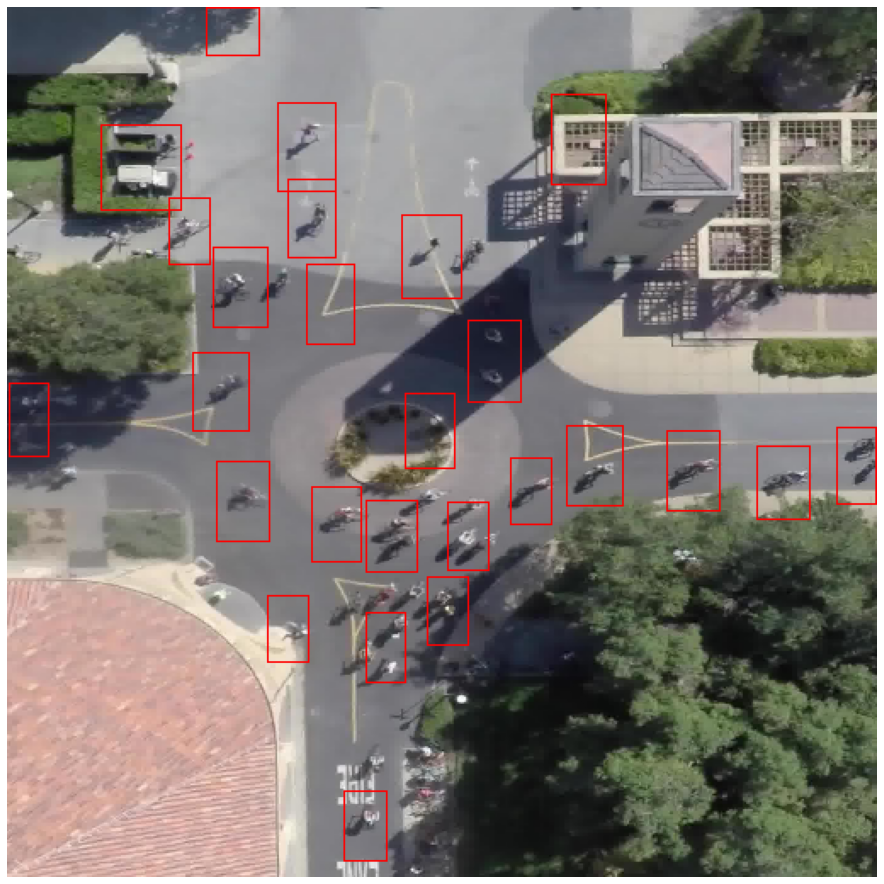

In [7]:
# fname = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages/hyang_video3_400.jpg'
fname = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages/deathCircle_video3_2078.jpg'
image = cv2.imread(fname, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
frame_size = max(1024, image.shape[0])
image = image[:frame_size, :frame_size]
image = cv2.resize(image, (512, 512))
image /= 255.0
t = torch.tensor(image).permute(2,0,1)
predictions,det = make_predictions(net,t)
boxes, scores, labels = run_wbf(predictions,0)
boxes = boxes.astype(np.int32).clip(min=0, max=511)
for box,label in zip(boxes,labels):
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), label_colors[label], 1)

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
ax.set_axis_off()
ax.imshow(image)

In [ ]:
#Batch version. needs make_prediction to be changed too
# image = t(frame)
# batch = torch.zeros((4,3,512,512),dtype=torch.float32)
# batch[0] = image[:,:512,:512]
# batch[1] = image[:,512:1024,:512]
# batch[2] = image[:,:512,512:1024]
# batch[3] = image[:,512:1024,512:1024]
# batch = batch.cuda().float()
# predictions,det = make_predictions(batch)
# patch = [None,None,None,None]
# patch[0] = frame[:512,:512]
# patch[1] = frame[512:1024,:512]
# patch[2] = frame[:512,512:1024]
# patch[3] = frame[512:1024,512:1024]

# for i in range(4):
#     boxes, scores, labels = run_wbf([predictions[i]])
#     boxes = boxes.astype(np.int32).clip(min=0, max=511)
#     for box,label in zip(boxes,labels):
#         cv2.rectangle(patch[i], (box[0], box[1]), (box[2], box[3]), label_colors[label], 1)

# fig, ax = plt.subplots(1, 1, figsize=(20, 16))
# ax.set_axis_off()
# ax.imshow(frame)
